In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return (loss.numpy() < threshold).astype(int)


def print_stats(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    print(f"Accuracy = {accuracy}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 score = {f1}")
    return accuracy, precision, recall, f1

In [23]:
metrics = []
confusion_matrixs = []

In [41]:
metrics

[{'n_layers': 3,
  'Precision': 1.0,
  'Recall': 0.7985425546542004,
  'false_positive_rate': 0.0},
 {'n_layers': 3,
  'Precision': 0.9996182981971931,
  'Recall': 0.9362023924102846,
  'false_positive_rate': 0.04887218045112782},
 {'n_layers': 5,
  'Precision': 0.9997674080534962,
  'Recall': 0.9456070397360099,
  'false_positive_rate': 0.03007518796992481},
 {'n_layers': 7,
  'Precision': 0.9997093107758496,
  'Recall': 0.9457170356111646,
  'false_positive_rate': 0.03759398496240601},
 {'n_layers': 9,
  'Precision': 0.9995354643904422,
  'Recall': 0.9467069984875567,
  'false_positive_rate': 0.06015037593984962}]

In [29]:
data = pd.read_csv("data.csv")

X = data.drop(columns=["Label", "Unnamed: 0"])
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
n_features = X.shape[1]

In [30]:
X.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '385', '386', '387', '388', '389', '390', '391', '392', '393', '394'],
      dtype='object', length=359)

# 3 layers

In [31]:
def create_autoencoder(input_dim, latent_dim = 16):
    input_layer = Input(shape=(input_dim,), name="Input")
    latent = Dense(latent_dim, activation="relu", name="Latent")(input_layer)
    output_layer = Dense(input_dim, activation="linear", name="Output")(latent)

    autoencoder = Model(input_layer, output_layer)
    return autoencoder

In [32]:
autoencoder = create_autoencoder(input_dim=n_features)
autoencoder.compile(optimizer="adadelta", loss="mse")
autoencoder.summary()

# Fit the model
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=64,
    epochs=10,
    verbose=0,
    validation_split=0.15,
    callbacks=[TqdmCallback(), EarlyStopping(patience=5)],
)

# Predict reconstruction errors for the training set
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train).numpy()
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

# Predict reconstruction errors for the test set
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test).numpy()
preds = predict(autoencoder, X_test, threshold)

# Calculate recall and confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

precision_score = tp / (tp + fp)
recall = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"Precision: {precision_score}")
print(f"Recall: {recall}")
print(f"False Positive Rate: {fpr}")
print(conf_matrix)

# Save the recall and false positive rate
metrics.append(
    {
        "n_layers": 3,
        "Precision": precision_score,
        "Recall": recall,
        "false_positive_rate": fpr,
    }
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 359)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent (Dense)                  │ (None, 16)             │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 359)            │         6,103 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,863 (46.34 KB)

 Trainable params: 11,863 (46.34 KB)

 Non-trainable params: 0 (0.00 B)























































































































































































































































































































































































































100%|██████████| 10/10 [00:32<00:00,  3.26s/epoch, loss=0.0338, val_loss=0.0335]


4579/4579 ━━━━━━━━━━━━━━━━━━━━ 4s 844us/step
Threshold:  0.11123401620514177
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step
Precision: 0.9996182981971931
Recall: 0.9362023924102846
False Positive Rate: 0.04887218045112782
[[  253    13]
 [ 2320 34045]]


In [21]:
fp, tn

(266, 0)

# 5 layers

In [33]:
def create_autoencoder(input_dim, latent_dim=16):
    input_layer = Input(shape=(input_dim,), name="Input")
    encoded = Dense(
        128,
        activation="relu",
        activity_regularizer=regularizers.l1(10e-5),
        name="Encoding",
    )(input_layer)
    latent = Dense(16, activation="relu", name="Latent")(encoded)
    decoded = Dense(128, activation="relu", name="Decoding")(latent)
    output_layer = Dense(input_dim, activation="linear", name="Output")(decoded)

    autoencoder = Model(input_layer, output_layer)
    return autoencoder

In [34]:
autoencoder = create_autoencoder(input_dim=n_features)
autoencoder.compile(optimizer="adadelta", loss="mse")
autoencoder.summary()

# Fit the model
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=64,
    epochs=20,
    verbose=0,
    validation_split=0.15,
    callbacks=[TqdmCallback(), EarlyStopping(patience=5)],
)

# Predict reconstruction errors for the training set
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train).numpy()
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

# Predict reconstruction errors for the test set
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test).numpy()
preds = predict(autoencoder, X_test, threshold)

# Calculate recall and confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

precision_score = tp / (tp + fp)
recall = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"Precision: {precision_score}")
print(f"False Positive Rate: {fpr}")
print(conf_matrix)

# Save the recall and false positive rate
metrics.append(
    {
        "n_layers": 5,
        "Precision": precision_score,
        "Recall": recall,
        "false_positive_rate": fpr,
    }
)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 359)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding (Dense)                │ (None, 128)            │        46,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent (Dense)                  │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 359)            │        46,311 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,631 (377.46 KB)

 Trainable params: 96,631 (377.46 KB)

 Non-trainable params: 0 (0.00 B)

4579/4579 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Threshold:  0.0947496752069323
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Precision: 0.9997674080534962
False Positive Rate: 0.03007518796992481
[[  258     8]
 [ 1978 34387]]


# 7 layers

In [35]:
def create_autoencoder(input_dim, latent_dim=16):
    input_layer = Input(shape=(input_dim,), name="Input")
    encoded = Dense(
        256,
        activation="relu",
        activity_regularizer=regularizers.l1(10e-5),
        name="Encoding_1",
    )(input_layer)

    encoded = Dense(
        64,
        activation="relu",
        activity_regularizer=regularizers.l1(10e-5),
        name="Encoding_2",
    )(encoded)
    latent = Dense(latent_dim, activation="relu", name="Latent")(encoded)
    decoded = Dense(64, activation="relu", name="Decoding_1")(latent)
    decoded = Dense(256, activation="relu", name="Decoding_2")(decoded)
    output_layer = Dense(input_dim, activation="linear", name="Output")(decoded)
    autoencoder = Model(input_layer, output_layer)

    return autoencoder

In [36]:
autoencoder = create_autoencoder(input_dim=n_features)
autoencoder.compile(optimizer="adadelta", loss="mse")
autoencoder.summary()

history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=64,
    epochs=20,
    verbose=0,
    validation_split=0.15,
    callbacks=[TqdmCallback(), EarlyStopping(patience=5)],
)
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train).numpy()
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test).numpy()
preds = predict(autoencoder, X_test, threshold)


conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

precision_score = tp / (tp + fp)
recall = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"Precision: {precision_score}")
print(f"False Positive Rate: {fpr}")
print(conf_matrix)
metrics.append(
    {
        "n_layers": 7,
        "Precision": precision_score,
        "Recall": recall,
        "false_positive_rate": fpr,
    }
)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 359)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_1 (Dense)              │ (None, 256)            │        92,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_2 (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent (Dense)                  │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_1 (Dense)              │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_2 (Dense)              │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 359)            │        92,263 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,639 (857.96 KB)

 Trainable params: 219,639 (857.96 KB)

 Non-trainable params: 0 (0.00 B)

4579/4579 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Threshold:  0.0957159814993725
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Precision: 0.9997093107758496
False Positive Rate: 0.03759398496240601
[[  256    10]
 [ 1974 34391]]


# 9 layers

In [37]:
def create_autoencoder(input_dim, latent_dim=16):
    input_layer = Input(shape=(input_dim,), name="Input")
    encoded = Dense(
        256,
        activation="relu",
        activity_regularizer=regularizers.l1(10e-5),
        name="Encoding_1",
    )(input_layer)

    encoded = Dense(
        128,
        activation="relu",
        activity_regularizer=regularizers.l1(10e-5),
        name="Encoding_2",
    )(encoded)

    # Third encoding layer
    encoded = Dense(
        64,
        activation="relu",
        activity_regularizer=regularizers.l1(10e-5),
        name="Encoding_3",
    )(encoded)

    # Latent layer (bottleneck)
    latent = Dense(latent_dim, activation="relu", name="Latent")(encoded)

    # First decoding layer
    decoded = Dense(64, activation="relu", name="Decoding_1")(latent)

    # Second decoding layer
    decoded = Dense(128, activation="relu", name="Decoding_2")(decoded)
    decoded = Dense(256, activation="relu", name="Decoding_3")(decoded)
    output_layer = Dense(input_dim, activation="linear", name="Output")(decoded)
    autoencoder = Model(input_layer, output_layer)

    return autoencoder

In [38]:
autoencoder = create_autoencoder(input_dim=n_features)
autoencoder.compile(optimizer="adadelta", loss="mse")
autoencoder.summary()

# Fit the model
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=64,
    epochs=20,
    verbose=0,
    validation_split=0.15,
    callbacks=[TqdmCallback(), EarlyStopping(patience=5)],
)

# Predict reconstruction errors for the training set
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train).numpy()
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

# Predict reconstruction errors for the test set
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test).numpy()
preds = predict(autoencoder, X_test, threshold)

# Calculate recall and confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

precision_score = tp / (tp + fp)
recall = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"Precision: {precision_score}")
print(f"Recall: {recall}")
print(f"False Positive Rate: {fpr}")
print(conf_matrix)

# Save the recall and false positive rate
metrics.append(
    {
        "n_layers": 9,
        "Precision": precision_score,
        "Recall": recall,
        "false_positive_rate": fpr,
    }
)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 359)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_1 (Dense)              │ (None, 256)            │        92,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_2 (Dense)              │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_3 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent (Dense)                  │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_1 (Dense)              │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_2 (Dense)              │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_3 (Dense)              │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 359)            │        92,263 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,047 (1.03 MB)

 Trainable params: 269,047 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

4579/4579 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Threshold:  0.09725167918289815
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Precision: 0.9995354643904422
Recall: 0.9467069984875567
False Positive Rate: 0.06015037593984962
[[  250    16]
 [ 1938 34427]]


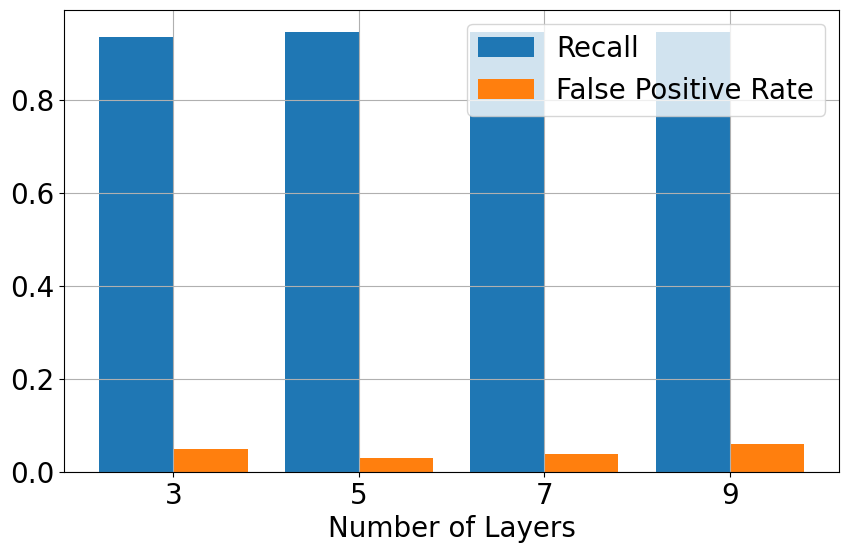

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics data
metrics = [
    {
        "n_layers": 3,
        "Precision": 0.9996182981971931,
        "Recall": 0.9362023924102846,
        "false_positive_rate": 0.04887218045112782,
    },
    {
        "n_layers": 5,
        "Precision": 0.9997674080534962,
        "Recall": 0.9456070397360099,
        "false_positive_rate": 0.03007518796992481,
    },
    {
        "n_layers": 7,
        "Precision": 0.9997093107758496,
        "Recall": 0.9457170356111646,
        "false_positive_rate": 0.03759398496240601,
    },
    {
        "n_layers": 9,
        "Precision": 0.9995354643904422,
        "Recall": 0.9467069984875567,
        "false_positive_rate": 0.06015037593984962,
    },
]

# Extract data for plotting
n_layers = [entry["n_layers"] for entry in metrics]
recall = [entry["Recall"] for entry in metrics]
fpr = [entry["false_positive_rate"] for entry in metrics]

# Create the figure
plt.figure(figsize=(10, 6))

width = 0.4
x = np.arange(len(n_layers))

# Create bars for Recall and False Positive Rate
plt.bar(x - width / 2, recall, width, label="Recall")
plt.bar(x + width / 2, fpr, width, label="False Positive Rate")
plt.xlabel("Number of Layers", fontsize=20)
plt.xticks(x, n_layers, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()

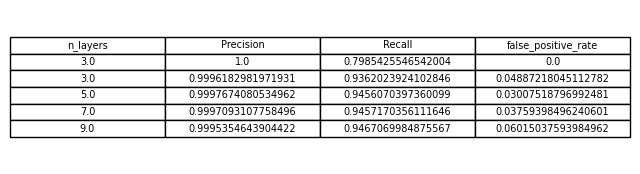

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the list of dictionaries into a DataFrame for easier visualization
df_metrics = pd.DataFrame(metrics)

# Create a figure for the table
fig, ax = plt.subplots(figsize=(8, 2))  # Set the figure size
ax.axis("tight")
ax.axis("off")

# Create the table
table = ax.table(
    cellText=df_metrics.values,
    colLabels=df_metrics.columns,
    cellLoc="center",
    loc="center",
)

# Display the table
plt.show()

Kernel: poly - Precision: 0.9923012275094625, Recall: 0.8893666153507808, False Positive Rate: 0.984313725490196
[[    20   1255]
 [ 20122 161758]]
Kernel: rbf - Precision: 0.9990778713387852, Recall: 0.9054541455904992, False Positive Rate: 0.1192156862745098
[[  1123    152]
 [ 17196 164684]]
Kernel: linear - Precision: 0.9920142827678663, Recall: 0.8462337805146251, False Positive Rate: 0.971764705882353
[[    36   1239]
 [ 27967 153913]]
Kernel: sigmoid - Precision: 0.9927323465178355, Recall: 0.8997250934682208, False Positive Rate: 0.9396078431372549
[[    77   1198]
 [ 18238 163642]]


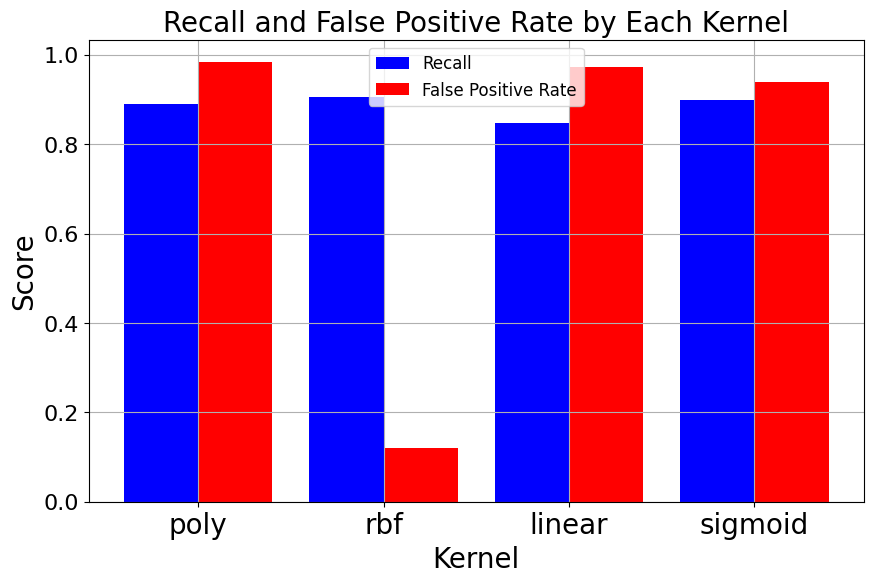

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
data = pd.read_csv("data.csv")
X = data.drop(columns=["Label", "Unnamed: 0"])
y = data["Label"]



kernels = ["poly", "rbf", "linear", "sigmoid"]
results = {}
metrics = []

# Train One-Class SVM with each kernel and evaluate
for kernel in kernels:
    n_components = min(20, X.shape[1])
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(X)
    reduced_df = pd.DataFrame(
        reduced_data, columns=[f"Component {i+1}" for i in range(n_components)]
    )

    oc_svm = OneClassSVM(kernel=kernel, gamma="auto", nu=0.1)
    oc_svm.fit(reduced_df)
    y_pred = oc_svm.predict(reduced_df)
    y_pred = [0 if x == -1 else 1 for x in y_pred]

    # Calculate confusion matrix and metrics
    conf_matrix = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    precision_score_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(
        f"Kernel: {kernel} - Precision: {precision_score_val}, Recall: {recall}, False Positive Rate: {fpr}"
    )
    print(conf_matrix)

    # Save the metrics
    metrics.append(
        {
            "Kernel": kernel,
            "Precision": precision_score_val,
            "Recall": recall,
            "false_positive_rate": fpr,
        }
    )

# Extract data for plotting
kernels_list = [metric["Kernel"] for metric in metrics]
recalls = [metric["Recall"] for metric in metrics]  # Recall values
fprs = [metric["false_positive_rate"] for metric in metrics]  # FPR values

# Create the figure
plt.figure(figsize=(10, 6))

width = 0.4
x = np.arange(len(kernels_list))

# Create bars for Recall and False Positive Rate
plt.bar(x - width / 2, recalls, width, label="Recall", color="blue")
plt.bar(x + width / 2, fprs, width, label="False Positive Rate", color="red")

# Set titles and labels with increased font size
plt.title("Recall and False Positive Rate by Each Kernel", fontsize=20)
plt.xlabel("Kernel", fontsize=20)
plt.ylabel("Score", fontsize=20)

# Set x-ticks with kernel names
plt.xticks(x, kernels_list, fontsize=20)

# Set y-ticks with increased font size
plt.yticks(fontsize=16)

# Add a legend with increased font size
plt.legend(fontsize=12)

# Enable grid
plt.grid(True)

# Show the plot
plt.show()

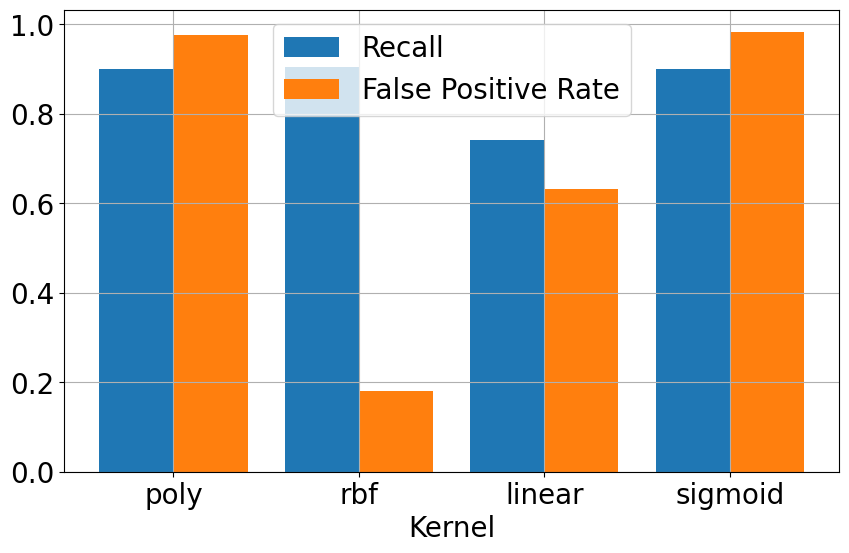

In [12]:
import numpy as np
import matplotlib.pyplot as plt

metrics = [
    {
        "Kernel": "poly",
        "Precision": 0.9924518227270521,
        "Recall": 0.8992962392786452,
        "False Positive Rate": 0.9756862745098039,
    },
    {
        "Kernel": "rbf",
        "Precision": 0.9986107825116324,
        "Recall": 0.9050582801847372,
        "False Positive Rate": 0.1796078431372549,
    },
    {
        "Kernel": "linear",
        "Precision": 0.9940675343051277,
        "Recall": 0.7416373433032769,
        "False Positive Rate": 0.6313725490196078,
    },
    {
        "Kernel": "sigmoid",
        "Precision": 0.9923935921776527,
        "Recall": 0.8995326588959753,
        "False Positive Rate": 0.9835294117647059,
    },
]

# Extract recall and false positive rate
recall = [entry["Recall"] for entry in metrics]
fpr = [entry["False Positive Rate"] for entry in metrics]
kernels = [entry["Kernel"] for entry in metrics]
plt.figure(figsize=(10, 6))

width = 0.4
x = np.arange(len(kernels))

plt.bar(x - width / 2, recall, width, label="Recall")
plt.bar(x + width / 2, fpr, width, label="False Positive Rate")
plt.xlabel("Kernel", fontsize=20)

plt.xticks(x, kernels, fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)

plt.grid(True)
plt.show()